In [1]:
import sys
import os

# 모듈 경로 추가
model_upgrading_path = os.path.join("..","src")
sys.path.append(model_upgrading_path)

In [2]:
# moduel
from my_package.data.select_dataset import get_dataframe_from_database
import my_package.time_series as time

# basic
import pandas as pd
import numpy as np
import pickle

# visualize
import matplotlib.pyplot as plt  

# learning
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

<span style="color: blue; font-size: 14px; font-weight: bold; background-color: #f0f0f0; padding: 5px; border-radius: 5px;">
    스크립트 실행
</span>

goals: 특정 선박 활용 AI 모델 생성

테스트 선박 목록
1. AKRA
2. MASAN TEST150

In [3]:
# Goals: 데이터 생성 

data = time.create_electrode_data()

In [4]:
# Goals: 데이터 처리 (MASAN TEST150 선박 활용)

# 1. 선박 선택
ship_name = 'MASAN TEST150'

# 2. 선박 아이디 선택
ship_id = time.find_ship(ship_name)[0]

# 3. 데이터 처리
masan_etd = time.preprocess_data(data, ship_id)

# 4. 이동 평균 생성 ( 기준 250 분 )
masan_etd = time.generate_moving_average(masan_etd, 250)

In [5]:
# Goals: 시간(분) 기준 데이터 그룹화 ( 평균 효율 )

masan_etd_group = masan_etd[['DATA_TIME','Moving_Average']].groupby('DATA_TIME').mean().reset_index()

In [6]:
# Goals: 학습 데이터 프레임 생성

# 1. Datetime 형식으로 변환 
masan_etd_group['DATA_TIME'] = pd.to_datetime(masan_etd_group['DATA_TIME'])

# 2. Datetime을 인덱스로 설정
masan_etd_group.set_index('DATA_TIME', inplace=True)

# 3. 6시간 단위로 리샘플링 (3H = 3시간)
# 여기서 'mean'은 3시간 동안의 평균을 계산하는 방식
masan_etd_group_resampled = masan_etd_group.resample('3H').mean()
masan_etd_group_resampled = masan_etd_group_resampled.dropna()
masan_etd_group_resampled.reset_index(inplace=True)

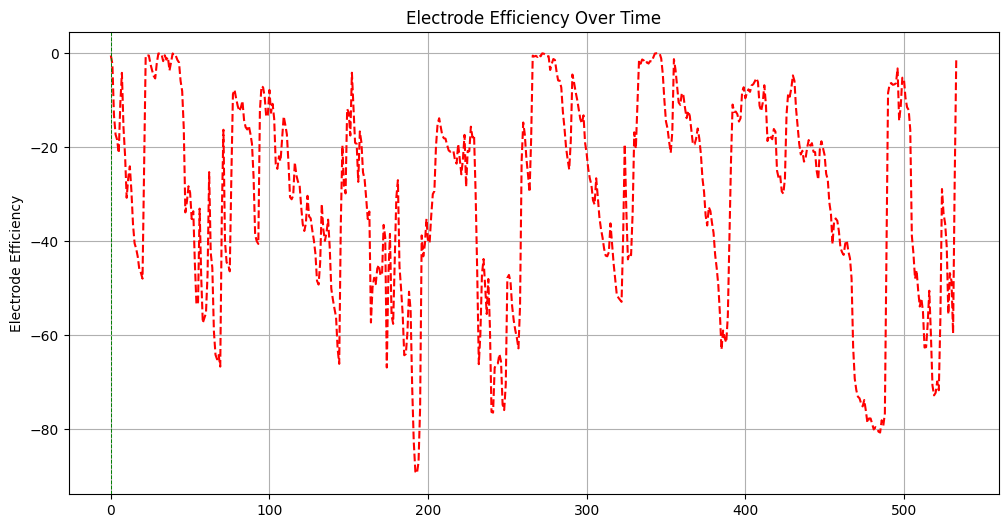

In [7]:
# Goals: 시각화를 이용한 탐색적 데이터 분석

time.plot_time_series(masan_etd_group_resampled)

Epoch 1/10
11/11 [==============================] - 1s 31ms/step - loss: 0.3858 - val_loss: 0.3444
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.1965 - val_loss: 0.1306
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0557 - val_loss: 0.0172
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0136
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0236 - val_loss: 0.0157
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0214 - val_loss: 0.0129
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0125
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0197 - val_loss: 0.0120
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0194 - val_loss: 0.0124
Epoch 10/10
4/4 [==============================] - 0s 5ms/step


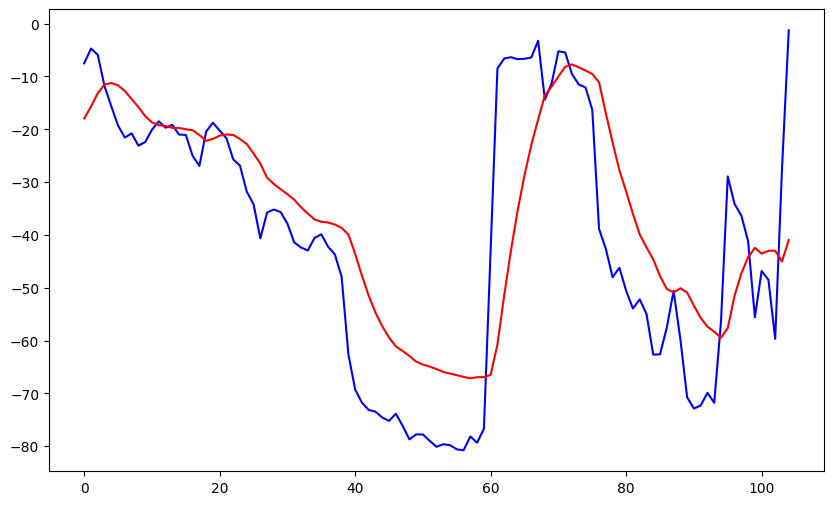

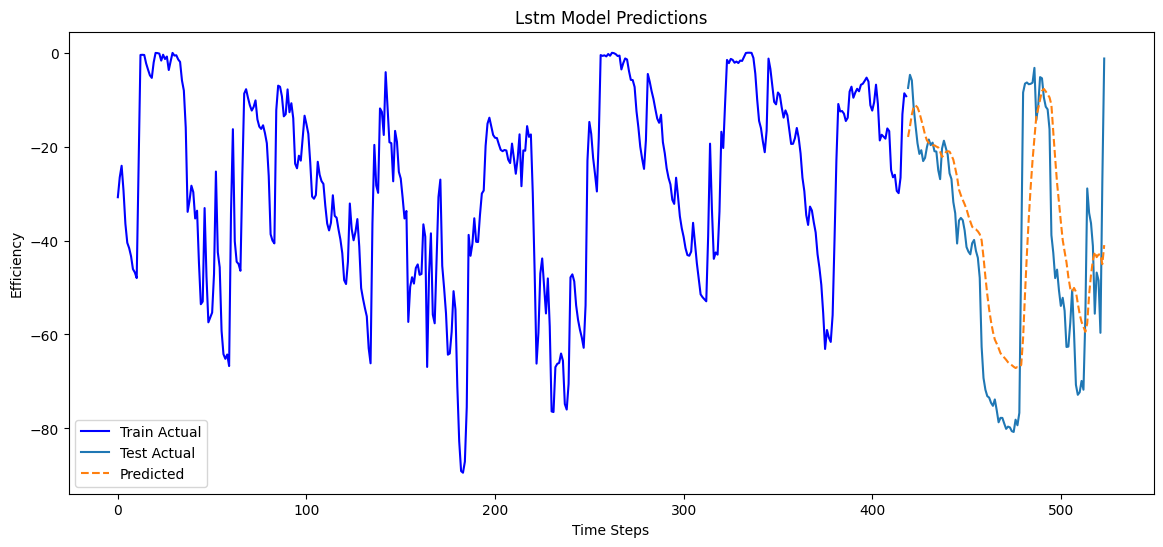

Root Mean Squared Error (RMSE): 15.366180003972365


In [9]:
# Goals: 모델 학습

# 1. 학습 데이터 생성
X_train,X_test,y_train,y_test,scaler = time.make_train_dataset(masan_etd_group_resampled, 10)

# 2. 모델 개발
lstm_model = time.train_lstm_obj(X_train,y_train,10)

# 2.5. 모델 로드
# lstm_model = time.load_model_from_pickle('time_model_250_3h_10.pkl')

# 3. 모델 예측
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 4. 예측 값 시각화
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label = 'Train Actual', color='blue')
plt.plot(predictions, label = 'Prediction', color='red')

# 5. 예측 결과 시각화
y_test_rescaled, predictions = time.plot_predict_values(lstm_model,X_test,y_train,y_test,scaler)

# 6. 평가 지표 생성
time.calculate_evaluation(y_test_rescaled, predictions)

In [ ]:
# Goals: 피클 파일로 모델 저장

# 1. 모델을 피클 파일로 저장
model_name = 'time_model_250_3h_10.pkl'

time.save_model_from_pickle(model_name, lstm_model)

In [ ]:
# Goals: 파일 경로를 지정하여 모델을 로드
loaded_model = load_model_from_pickle('time_model.pkl')

# 모델 사용 예시
if loaded_model:
    # 로드한 모델을 사용하여 예측
    # 예: predictions = loaded_model.predict(X_test)
    pass

In [24]:
# Goals: 단계별 예측 사용 
current_sequence, predicted_values = time.make_step_by_step_prediction(X_train,lstm_model, 100)

1/1 [==============================] - 0s 27ms/step


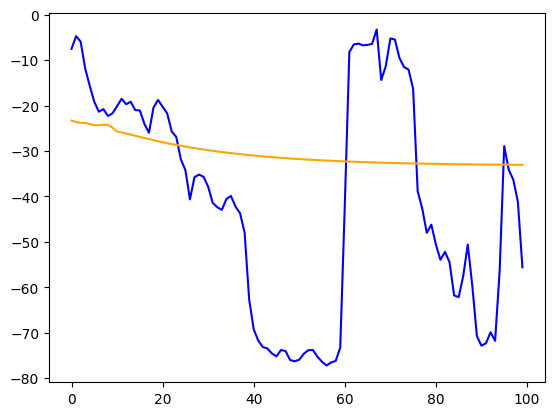

In [38]:
# Goals: 단계별 예측 정확도 확인
predictions = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test[:100].reshape(-1, 1))

plt.plot(y_test_rescaled, label = 'Train Actual', color='blue')
plt.plot(predictions, label = 'Prediction', color='orange')